# Initialisation

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
EMP=pd.read_csv("https://raw.githubusercontent.com/kilianguillon/Projet_statapp/main/data/EMP_deplacements_Charme.csv",
                sep=";", encoding='latin-1')
EMP.head()

,IDENT_IND,IDENT_MEN,MVEH,POND_JOUR,MOTPREC,MMOTIFDES,MSTATION,Motif,Stationnement,Lieu_Depart,...,MVEHEXT,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,KVAQUIV,TRAVAILLE,Segment_detail,IDENT_V,Segment,num_dep_V
0,110000011400001,1100000114000,1,"9891,108772",1.1,2.1,5,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,...,NaN,2029-01-03 14:15:00,2029-01-03 14:20:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,1
1,110000011400001,1100000114000,1,"9891,108772",2.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,NaN,2029-01-03 14:45:00,2029-01-03 14:50:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,2
2,110000011500001,1100000115000,2,"5275,2959481",1.1,1.4,6,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,...,NaN,2029-01-05 07:45:00,2029-01-05 08:45:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,1
3,110000011500001,1100000115000,2,"5275,2959481",1.4,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,NaN,2029-01-05 10:30:00,2029-01-05 11:00:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,2
4,110000013500002,1100000135000,1,"24058,724023",1.1,9.1,4,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,...,NaN,2029-01-03 15:00:00,2029-01-03 15:15:00,"5,3214103219",1.0,1,Particulier,110000013500002_1_Particulier,Particulier,1


In [69]:
#Création d'une base ne prenant que les premiers trajets
EMP_prems = EMP[EMP["num_dep_V"]==1]
EMP_prems.columns.tolist()

['IDENT_IND',
 'IDENT_MEN',
 'MVEH',
 'POND_JOUR',
 'MOTPREC',
 'MMOTIFDES',
 'MSTATION',
 'Motif',
 'Stationnement',
 'Lieu_Depart',
 'Lieu_Arrivee',
 'TYPE_jour',
 'HEURE_DEPART',
 'HEURE_ARRIVEE',
 'MVEHEXT',
 'INSTANT_DEPART',
 'INSTANT_ARRIVEE',
 'DISTANCE',
 'KVAQUIV',
 'TRAVAILLE',
 'Segment_detail',
 'IDENT_V',
 'Segment',
 'num_dep_V']

# Lieu du premier déplacement de la journée

In [4]:
EMP_prems["Motif"].value_counts() #Motif du déplacement (pas de pondération)

Motif
Travailler dans son lieu fixe et habituel                                                                                                                                    1838
Se rendre dans une grande surface ou un centre commercial (y compris boutiques et services)                                                                                  1111
Se rendre dans un centre de proximité, petit commerce, supérette, boutiques, services (banque, cordonnier.) (hors centre commercial)                                          891
Visite à la famille                                                                                                                                                           471
Accompagner quelqu'un à un autre endroit                                                                                                                                      408
Soins médicaux ou personnels (médecin, coiffeur.)                                                       

In [5]:
#Arrivée du déplacement pas de pond
EMP_prems["Lieu_Arrivee"].value_counts()

Lieu_Arrivee
Rue           2577
Parking       2486
Entreprise    1441
Domicile       570
Sans           275
Name: count, dtype: int64

In [134]:
def count_occ_pond(data, nom_var, nom_pond, taille=10):
    value = data[nom_var].unique() #cette fonction est utile pour des variables prenant un nbre de valeurs finies
    result_dict = {nom_var: [], 'Occurences pondérées': [], 'Proportion':[]} #à chaque valeur on associe la somme des occurences pondérées
    N=data[nom_pond].replace(',', '.', regex=True).astype(float).sum()
    for val in value :
        somme_pond = data[data[nom_var] == val][nom_pond].replace(',', '.', regex=True).astype(float).sum() #replace car la base utilisée est "française"
        result_dict[nom_var].append(val)
        result_dict['Occurences pondérées'].append(somme_pond)
        result_dict['Proportion'].append(round(100*somme_pond/N,2))
    return pd.DataFrame(result_dict).sort_values('Occurences pondérées', ascending=False).reset_index(drop=True).head(taille)

In [135]:
count_occ_pond(EMP_prems, "Motif", "POND_JOUR")

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.820732e+07,27.04
1,Se rendre dans une grande surface ou un centre...,2.253802e+07,12.64
2,"Se rendre dans un centre de proximité, petit c...",1.891414e+07,10.61
3,Accompagner quelqu'un à un autre endroit,1.351374e+07,7.58
4,Visite à la famille,1.072364e+07,6.02
5,"Soins médicaux ou personnels (médecin, coiffeur.)",6.666349e+06,3.74
6,Visite à des amis,6.128020e+06,3.44
7,Faire du sport,5.893799e+06,3.31
8,Aller chercher quelqu'un à un autre endroit,5.076578e+06,2.85
9,Travailler en dehors d'un lieu fixe et habitue...,4.679032e+06,2.62


In [84]:
count_occ_pond(EMP_prems, "Lieu_Arrivee", "POND_JOUR")

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,6.142194e+07,34.45
1,Parking,5.700055e+07,31.97
2,Entreprise,3.775752e+07,21.18
3,Domicile,1.366802e+07,7.67
4,Sans,8.432261e+06,4.73


# Lieu en fonction de l'heure d'arrivée et du jour

## Week_end ou non ?

In [80]:
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP_prems.loc[:, "WE"] = 0
EMP_prems.loc[EMP_prems["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1

WE
0    5861
1    1488
Name: count, dtype: int64

On regroupe samedi et dimanche pour simplifier. Les habitudes de premier déplacement sont légèrement différentes (plus de visite à la famille ou retour au domicile le dimanche), mais ces deux jours différent encore plus avec les autres.

In [93]:
count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="samedi"], "Motif", "POND_JOUR"), count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="dimanche"], "Motif", "POND_JOUR") #le week-end

(                                               Motif  Occurences pondérées  \
 0  Se rendre dans une grande surface ou un centre...          6.155284e+06   
 1  Se rendre dans un centre de proximité, petit c...          3.982803e+06   
 2          Travailler dans son lieu fixe et habituel          2.331539e+06   
 3                                  Visite à des amis          1.476392e+06   
 4                                Visite à la famille          1.452123e+06   
 5           Accompagner quelqu'un à un autre endroit          1.328997e+06   
 6                                     Faire du sport          1.111904e+06   
 7                 Se rendre sur un lieu de promenade          6.457371e+05   
 8  Soins médicaux ou personnels (médecin, coiffeur.)          5.484626e+05   
 9  Voir un spectacle culturel ou sportif (cinéma,...          5.157151e+05   
 
    Proportion  
 0       26.44  
 1       17.11  
 2       10.01  
 3        6.34  
 4        6.24  
 5        5.71  
 6        

In [94]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Motif", "POND_JOUR") #en semaine

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.473707e+07,33.36
1,Se rendre dans une grande surface ou un centre...,1.471521e+07,10.97
2,Accompagner quelqu'un à un autre endroit,1.151086e+07,8.58
3,"Se rendre dans un centre de proximité, petit c...",1.102945e+07,8.23
4,"Soins médicaux ou personnels (médecin, coiffeur.)",6.023393e+06,4.49
5,Visite à la famille,5.599544e+06,4.18
6,Travailler en dehors d'un lieu fixe et habitue...,4.283752e+06,3.19
7,Aller chercher quelqu'un à un autre endroit,4.032286e+06,3.01
8,Visite à des amis,3.655889e+06,2.73
9,Faire du sport,3.294035e+06,2.46


In [95]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Lieu_Arrivee", "POND_JOUR") #en semaine

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,4.455184e+07,33.22
1,Parking,3.935525e+07,29.35
2,Entreprise,3.467059e+07,25.85
3,Domicile,8.618989e+06,6.43
4,Sans,6.899742e+06,5.15


In [96]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Motif", "POND_JOUR") #le WE

,Motif,Occurences pondérées,Proportion
0,"Se rendre dans un centre de proximité, petit c...",7.884686e+06,17.85
1,Se rendre dans une grande surface ou un centre...,7.822811e+06,17.71
2,Visite à la famille,5.124099e+06,11.60
3,Travailler dans son lieu fixe et habituel,3.470241e+06,7.85
4,Faire du sport,2.599764e+06,5.88
5,Visite à des amis,2.472131e+06,5.60
6,"Activité associative, cérémonie religieuse, ré...",2.151604e+06,4.87
7,Accompagner quelqu'un à un autre endroit,2.002878e+06,4.53
8,Se rendre sur un lieu de promenade,1.963082e+06,4.44
9,Manger ou boire à l'extérieur du domicile,1.185048e+06,2.68


In [99]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Lieu_Arrivee", "POND_JOUR") #le WE

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Parking,1.764530e+07,39.94
1,Rue,1.687010e+07,38.18
2,Domicile,5.049031e+06,11.43
3,Entreprise,3.086933e+06,6.99
4,Sans,1.532519e+06,3.47


## Premier lieu par heure

In [124]:
for h in range(0,24):
    EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR") #heure d'arrivée du premier trajet en semaine

,H_ARR,Occurences pondérées,Proportion
0,8.0,2.976929e+07,22.20
1,7.0,2.213325e+07,16.51
2,9.0,1.832836e+07,13.67
3,10.0,1.298932e+07,9.69
4,11.0,7.437903e+06,5.55
5,14.0,7.204150e+06,5.37
6,6.0,5.256828e+06,3.92
7,15.0,4.539262e+06,3.39
8,13.0,4.047905e+06,3.02
9,12.0,3.677261e+06,2.74


In [136]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24) #heure d'arrivée du premier trajet en WE

,H_ARR,Occurences pondérées,Proportion
0,10.0,8.597888e+06,19.46
1,9.0,5.796881e+06,13.12
2,11.0,5.751904e+06,13.02
3,8.0,3.457154e+06,7.82
4,14.0,3.374319e+06,7.64
5,15.0,3.269877e+06,7.40
6,16.0,2.563478e+06,5.80
7,12.0,2.548125e+06,5.77
8,13.0,1.920453e+06,4.35
9,7.0,1.414345e+06,3.20


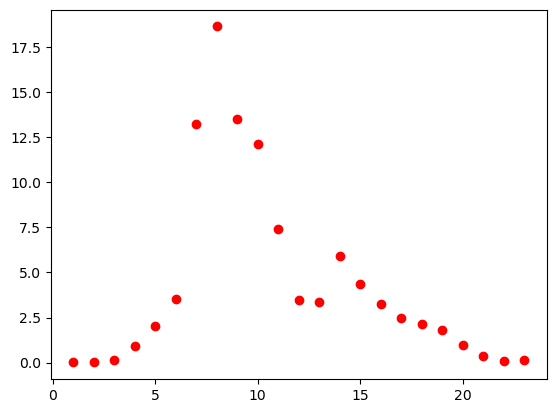

In [139]:
plt.plot(count_occ_pond(EMP_prems, "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_prems, "H_ARR", "POND_JOUR",24)["Proportion"],'ro')

In [176]:
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_prems[EMP_prems["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)


In [178]:
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion")
ax.set_title("Évolution des Proportions par Lieu d'Arrivée")
ax.legend()
plt.show()